# Final Exam Paper - Logo Classification on Luxury Car Brands

Emilia Paulina Gachowetz-Geppel, 154843 

Isabella Julia Schrüfer, 167575 

Simon Lucas Stohrer, 172845 

Veronica Larsson, 167337 

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow import keras 
from tensorflow.keras import layers
import os
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, BatchNormalization, AveragePooling2D, Flatten
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import aspose.words as aw
from sklearn.decomposition import PCA
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from tensorflow.keras import models, optimizers
from tensorflow.keras.applications import ResNet50

## First (larger) dataset

In [ ]:
'''Convert all images to PNG -- run only one time (later needed for pre-trained model)'''

def save_images_as_png(folder_path, output_folder, image_size=(150, 150)):
    
    '''This function will convert all images of the first dataset intp PNG images, as the preferred mode for the later-used
    pre-trained model also contains the alpha channel.'''
    
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            if any(filename.endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
                try:
                    with Image.open(file_path) as img: #creating the output folder structure
                        relative_path = os.path.relpath(root, folder_path)
                        output_subfolder = os.path.join(output_folder, relative_path)
                        os.makedirs(output_subfolder, exist_ok=True)
                        if img.mode == 'CMYK':
                            img = img.convert('RGB')
                        output_file_path = os.path.join(output_subfolder, filename.split('.')[0] + '.png')
                        img = img.resize(image_size)  #resizing image
                        img.save(output_file_path, format='PNG')
                except Exception as e:
                    print(f"Error processing image '{file_path}': {e}")

#folder with original images
folder_path = r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\logo findder"

#output folder where png-images will be saved
output_folder=r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder"

save_images_as_png(folder_path, output_folder)

In [2]:
"""Getting df with all filenames and images"""

def load_images_from_folder(folder_path, image_size=(150, 150)):
    
    '''This function loads all the above converted png-images into a dataframe, but converts them to RGB mode,
    so without the alphachannel. The images are stored in subfolders, organized by brand'''
    
    images = []
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            if any(filename.endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
                try:
                    with Image.open(file_path) as img: #loading the image using PIL
                        img = img.resize(image_size) #resizing image
                        img = img.convert('RGB') #converting to RGB
                        label = os.path.basename(root) #getting the label
                        images.append({'Label': label, 'Filename': filename, 'Image': img})
                except Exception as e:
                    print(f"Error loading image '{file_path}': {e}")
    images_df = pd.DataFrame(images) #converting the list of dictionaries to a dataframe
    return images_df


png_folder_path=r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder"
image_df = load_images_from_folder(png_folder_path)

print('Image Dataframe: \n \n', image_df.head())

C:\Users\emili\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Error loading image 'C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder\Original Aston Martin logo\Image_30.png': Decompressed Data Too Large
Error loading image 'C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder\Original Maserati logo\Image_13.png': Decompressed Data Too Large
Error loading image 'C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder\Original Porsche logo\Image_18.png': Decompressed Data Too Large
Image Dataframe: 
 
                         Label      Filename  \
0  Original Aston Martin logo  Image_10.png   
1  Original Aston Martin logo  Image_11.png   
2  Original Aston Martin logo  Image_12.png   
3  Original Aston Martin logo  Image_13.png   
4  Original Aston Martin logo  Image_15.png   

                                               Image  
0  <PIL.Image.Image image mode=RGB size=150x150 a...  
1  <PIL.Image.Im

In [5]:
"""Run to get an overview of the data"""

#Get an overview of the number of images per label
labelinfo = image_df['Label'].value_counts() 
print('About the Distribtion of Labels:')
print('The number of different brands is', len(labelinfo))
print('The number of images per brand ranges from',labelinfo.min(),'to', labelinfo.max())
print('The average is',labelinfo.mean().round(),'and the median is', labelinfo.median())

#Get an overivew of image characteristics (size, channels) in the dataset
def get_image_characteristics(image):
    size = image.size  
    mode = image.mode  
    return size, mode

image_sizes = []
image_modes = []
for index, row in image_df.iterrows():
    size, mode = get_image_characteristics(row['Image'])  
    image_sizes.append(size)
    image_modes.append(mode)

image_characteristics_df = pd.DataFrame({'Size': image_sizes, 'Mode': image_modes})

#Print an overview of the image characteristics
print('\nAbout the Images in the Dataset:')
print('The number of different sizes is', len(image_characteristics_df['Size'].unique()))
print('Image size(s) in the dataset:', image_characteristics_df['Size'].unique())
print('The number of different color modes is', len(image_characteristics_df['Mode'].unique()))
print('Color mode(s) in the dataset:', image_characteristics_df['Mode'].unique())

#Get an overivew of the first rows of df
print('\n')
print('Quick view of dataframe:')
image_df.head()

About the Distribtion of Labels:
The number of different brands is 14
The number of images per brand ranges from 19 to 29
The average is 26.0 and the median is 27.0

About the Images in the Dataset:
The number of different sizes is 1
Image size(s) in the dataset: [(150, 150)]
The number of different color modes is 1
Color mode(s) in the dataset: ['RGB']


Quick view of dataframe:


,Label,Filename,Image
0,Original Aston Martin logo,Image_10.png,<PIL.Image.Image image mode=RGB size=150x150 a...
1,Original Aston Martin logo,Image_11.png,<PIL.Image.Image image mode=RGB size=150x150 a...
2,Original Aston Martin logo,Image_12.png,<PIL.Image.Image image mode=RGB size=150x150 a...
3,Original Aston Martin logo,Image_13.png,<PIL.Image.Image image mode=RGB size=150x150 a...
4,Original Aston Martin logo,Image_15.png,<PIL.Image.Image image mode=RGB size=150x150 a...


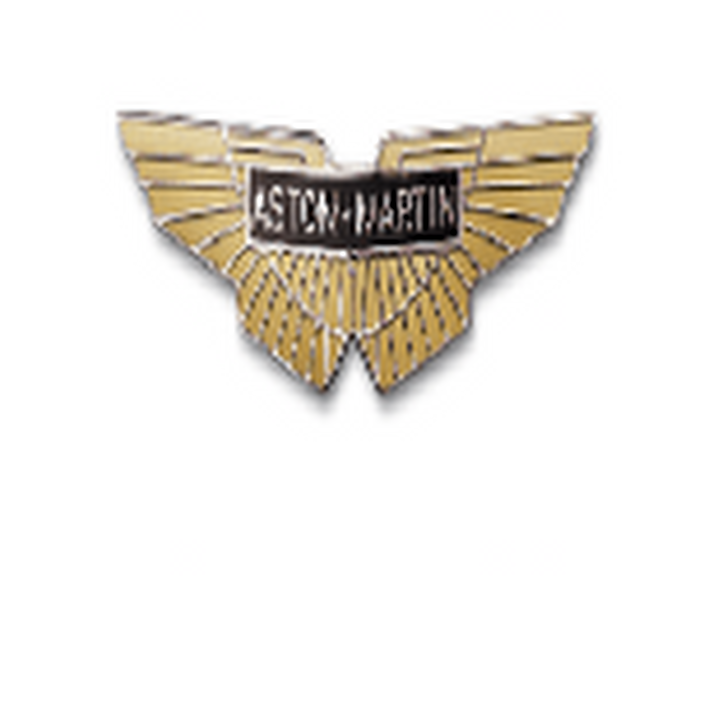

In [61]:
#selecting one picture from the DataFrame
some_pic = image_df['Image'].iloc[7]

plt.imshow(some_pic, interpolation="lanczos")
plt.axis("off")
plt.show()

In [3]:
'''Now we need to rename the car brands to ensure consitency with the second dataset, this is necessary for merging'''

image_df['Label'] = image_df['Label'].str.replace('Original', '').str.replace('logo', '').str.replace(' ', '')
image_df

,Label,Filename,Image
0,AstonMartin,Image_10.png,<PIL.Image.Image image mode=RGB size=150x150 a...
1,AstonMartin,Image_11.png,<PIL.Image.Image image mode=RGB size=150x150 a...
2,AstonMartin,Image_12.png,<PIL.Image.Image image mode=RGB size=150x150 a...
3,AstonMartin,Image_13.png,<PIL.Image.Image image mode=RGB size=150x150 a...
4,AstonMartin,Image_15.png,<PIL.Image.Image image mode=RGB size=150x150 a...
...,...,...,...
365,Porsche,Image_5.png,<PIL.Image.Image image mode=RGB size=150x150 a...
366,Porsche,Image_6.png,<PIL.Image.Image image mode=RGB size=150x150 a...
367,Porsche,Image_7.png,<PIL.Image.Image image mode=RGB size=150x150 a...
368,Porsche,Image_8.png,<PIL.Image.Image image mode=RGB size=150x150 a...


## Second (small) dataset

In [4]:
'''Read in the second data set'''

image_directory = r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\USA Car Logos"

image_filenames = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]

def process_images(image_directory, image_filenames):
    
    '''This dunction works similiar as the one above, just the folder sructure is a bit different.
    Here all images are stored in the same folder, not split up in sub-folders by brand.'''
    
    image_data = []
    for filename in image_filenames:
        try:
            image_path = os.path.join(image_directory, filename)  
            img = Image.open(image_path)  
            img = img.convert('RGB') 
            img_resized = img.resize((150, 150), Image.LANCZOS)  
            image_data.append({'Filename': filename, 'Image': img_resized})
        except Exception as e:
            print(f"Error processing image {filename}: {e}")
    image_df = pd.DataFrame(image_data)
    return image_df

image2_df=process_images(image_directory, image_filenames)
image2_df

,Filename,Image
0,AstonMartin.png,<PIL.Image.Image image mode=RGB size=150x150 a...
1,Audi.png,<PIL.Image.Image image mode=RGB size=150x150 a...
2,Bentley.png,<PIL.Image.Image image mode=RGB size=150x150 a...
3,Ferrari.png,<PIL.Image.Image image mode=RGB size=150x150 a...
4,FiskerAutomotive.png,<PIL.Image.Image image mode=RGB size=150x150 a...
5,Ford.png,<PIL.Image.Image image mode=RGB size=150x150 a...
6,Lamborghini.png,<PIL.Image.Image image mode=RGB size=150x150 a...
7,LotusCars.png,<PIL.Image.Image image mode=RGB size=150x150 a...
8,Maserati.png,<PIL.Image.Image image mode=RGB size=150x150 a...
9,Mercedes-AMG.png,<PIL.Image.Image image mode=RGB size=150x150 a...


In [8]:
"""Run to get an overview of this dataset as well"""

#Get an overview of the number of images per label
labelinfo2 = image2_df['Filename'].value_counts() 
print('About the Distribtion of Labels:')
print('The number of different brands is', len(labelinfo2))
print('The number of images per brand ranges from',labelinfo2.min(),'to', labelinfo2.max())
print('The average is',labelinfo2.mean().round(),'and the median is', labelinfo2.median())

#Get an overivew of image characteristics (size, channels) in the dataset
def get_image_characteristics(image):
    size = image.size
    mode = image.mode 
    return size, mode

image_sizes = []
image_modes = []
for index, row in image2_df.iterrows():
    size, mode = get_image_characteristics(row['Image']) 
    image_sizes.append(size)
    image_modes.append(mode)

image_characteristics_df2 = pd.DataFrame({'Size': image_sizes, 'Mode': image_modes})

#Print an overview of the image characteristics
print('\nAbout the Images in the Dataset:')
print('The number of different sizes is', len(image_characteristics_df2['Size'].unique()))
print('Image size(s) in the dataset:', image_characteristics_df2['Size'].unique())
print('The number of different color modes is', len(image_characteristics_df2['Mode'].unique()))
print('Color mode(s) in the dataset:', image_characteristics_df2['Mode'].unique())

#Get an overivew of the first rows of this df
print('\n')
print('Quick view of dataframe:')
image2_df.head()

About the Distribtion of Labels:
The number of different brands is 11
The number of images per brand ranges from 1 to 1
The average is 1.0 and the median is 1.0

About the Images in the Dataset:
The number of different sizes is 1
Image size(s) in the dataset: [(150, 150)]
The number of different color modes is 1
Color mode(s) in the dataset: ['RGB']


Quick view of dataframe:


,Filename,Image
0,AstonMartin.png,<PIL.Image.Image image mode=RGB size=150x150 a...
1,Audi.png,<PIL.Image.Image image mode=RGB size=150x150 a...
2,Bentley.png,<PIL.Image.Image image mode=RGB size=150x150 a...
3,Ferrari.png,<PIL.Image.Image image mode=RGB size=150x150 a...
4,FiskerAutomotive.png,<PIL.Image.Image image mode=RGB size=150x150 a...


In [5]:
#rename files here as well
image2_df['Label'] = image2_df['Filename'].apply(lambda x: x.split('.')[0])
image2_df

,Filename,Image,Label
0,AstonMartin.png,<PIL.Image.Image image mode=RGB size=150x150 a...,AstonMartin
1,Audi.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Audi
2,Bentley.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Bentley
3,Ferrari.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Ferrari
4,FiskerAutomotive.png,<PIL.Image.Image image mode=RGB size=150x150 a...,FiskerAutomotive
5,Ford.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Ford
6,Lamborghini.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Lamborghini
7,LotusCars.png,<PIL.Image.Image image mode=RGB size=150x150 a...,LotusCars
8,Maserati.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Maserati
9,Mercedes-AMG.png,<PIL.Image.Image image mode=RGB size=150x150 a...,Mercedes-AMG


## Data Augmentation

In [62]:
'''Since we have little data available, we will augment the data using tensorflow augmentation mechanisms.
It seems to be more common to add these layers right into a CNN model, but since we want to use the same augmented data
for our other models as well, we will do it separately.'''

img_size=150

#augmneting pipeline to plot
augment = tf.keras.Sequential([
    layers.Resizing(img_size, img_size), #resize again, to ensure every image is 150x150 for sure
    layers.RandomFlip(mode='horizontal_and_vertical'), #flipping it
    layers.RandomContrast(factor=0.2), #adjusting contrast
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomZoom(0.2), #zooming a bit
    layers.RandomBrightness([-0.3,0.3]), #adjusting colout brightness
    layers.RandomRotation(0.1), #randomly rotating
    layers.Rescaling(1./255) #rescaling in order to normalize
])

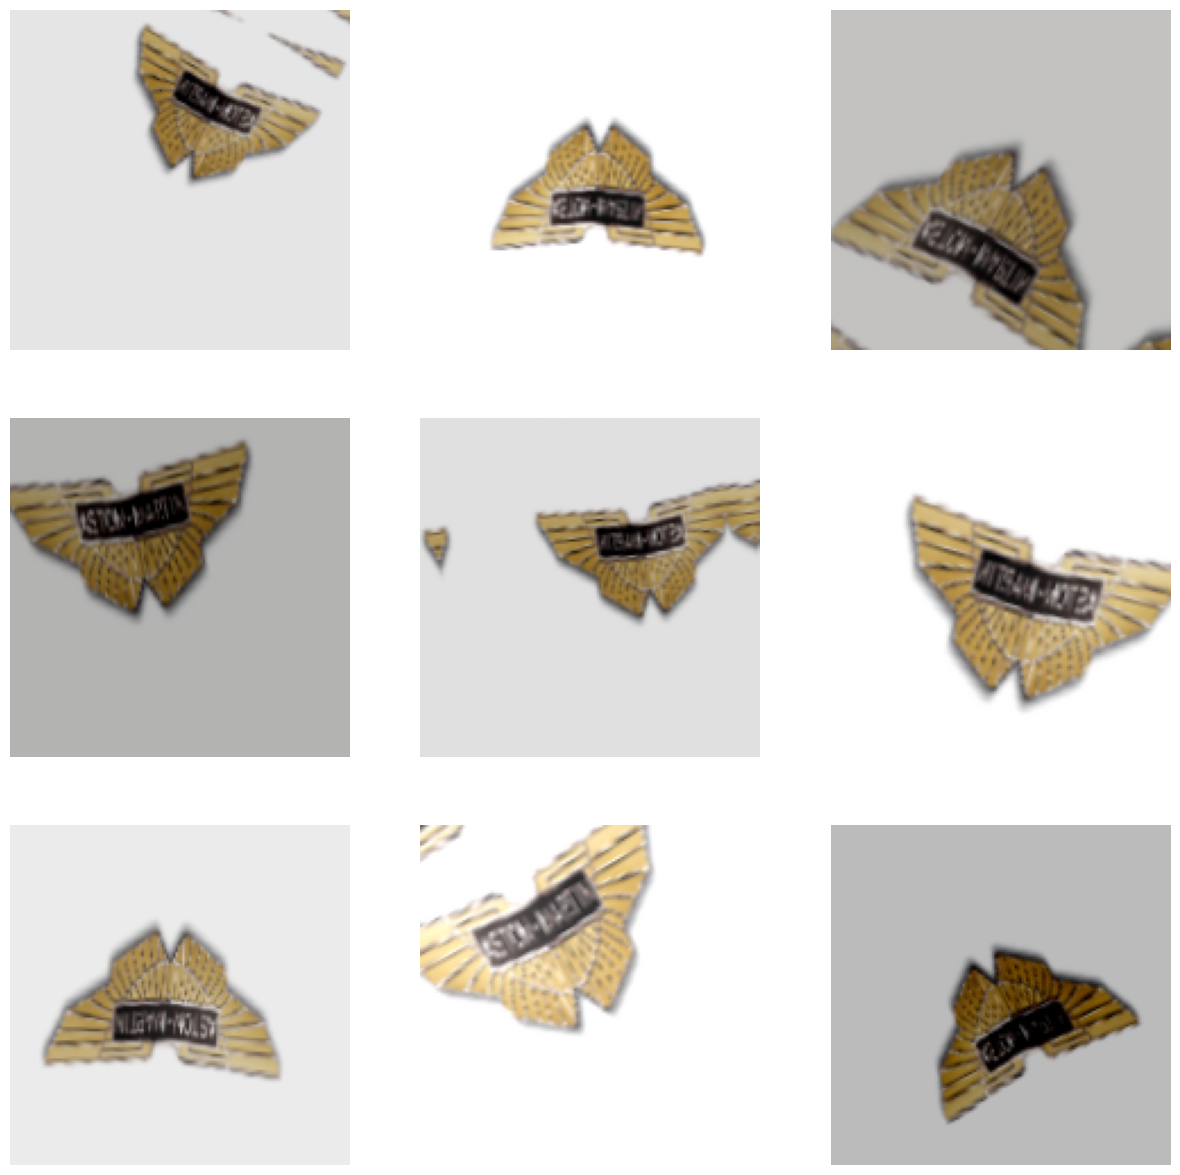

In [63]:
#plot one image
some_pic_tf = tf.cast(tf.expand_dims(some_pic, 0), tf.float32)

plt.figure(figsize=(15, 15))

for i in range(9):
    augmented_image = augment(some_pic_tf)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [6]:
#data augmentation

def augment_images(image, label, num_aug):
    
    '''This function applies a random sequence of augmentation to images in the DataFrame'''
    
    augmented_images = []
    
    #define the augmentation layers
    augmentation_layers = [
        layers.RandomFlip(mode='horizontal_and_vertical'), #flipping it
        layers.RandomContrast(factor=0.2), #adjusting contrast
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
        layers.RandomZoom(0.2), #zooming a bit
        layers.RandomBrightness([-0.3,0.3]), #adjusting colour brightness
        layers.RandomRotation(0.1), #randomly rotating
        layers.Rescaling(1./255) #rescaling in order to normalize
    ]
    
    #shuffle the augmentation layers
    random.shuffle(augmentation_layers)
    
    for _ in range(num_aug):
        for aug_func in augmentation_layers:
            augmented_image = aug_func(image)
            augmented_images.append((augmented_image, label))
    
    return augmented_images

In [7]:
#apply augmentation to our data (dataset 1)

#list to store augmented images
images_tensors = []

#apply augmentations to each image in the dataframe
for index, row in image_df.iterrows():
    image = row['Image']
    label = row['Label']
    augmented_images = augment_images(image, label, 5)
    images_tensors.extend(augmented_images)
augmented_df = pd.DataFrame(images_tensors, columns=['Augmented_Image', 'Label'])
augmented_df

,Augmented_Image,Label
0,"(((tf.Tensor(71.0, shape=(), dtype=float32), t...",AstonMartin
1,"(((tf.Tensor(0.2784314, shape=(), dtype=float3...",AstonMartin
2,"(((tf.Tensor(71.0, shape=(), dtype=float32), t...",AstonMartin
3,"(((tf.Tensor(68.06704, shape=(), dtype=float32...",AstonMartin
4,"(((tf.Tensor(66.374146, shape=(), dtype=float3...",AstonMartin
...,...,...
12945,"(((tf.Tensor(71.0, shape=(), dtype=float32), t...",Porsche
12946,"(((tf.Tensor(67.25045, shape=(), dtype=float32...",Porsche
12947,"(((tf.Tensor(71.0, shape=(), dtype=float32), t...",Porsche
12948,"(((tf.Tensor(71.0, shape=(), dtype=float32), t...",Porsche


In [8]:
#apply augmentation to our data (dataset 2)

#list to store augmented images
images_tensors_2 = []

#apply augmentations to each image in the dataframe
for index, row in image2_df.iterrows():
    image = row['Image']
    label = row['Label']
    augmented_images = augment_images(image, label, 10)
    images_tensors_2.extend(augmented_images)
augmented2_df = pd.DataFrame(images_tensors_2, columns=['Augmented_Image', 'Label'])
augmented2_df

,Augmented_Image,Label
0,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",AstonMartin
1,"(((tf.Tensor(250.90094, shape=(), dtype=float3...",AstonMartin
2,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",AstonMartin
3,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",AstonMartin
4,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",AstonMartin
...,...,...
765,"(((tf.Tensor(1.0, shape=(), dtype=float32), tf...",Porsche
766,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Porsche
767,"(((tf.Tensor(244.5429, shape=(), dtype=float32...",Porsche
768,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Porsche


## Merge and Encode the two dataframes

In [9]:
#merge
augmented_df_full = pd.concat([augmented_df, augmented2_df], ignore_index=True)
augmented_df_full

,Augmented_Image,Label
0,"(((tf.Tensor(71.0, shape=(), dtype=float32), t...",AstonMartin
1,"(((tf.Tensor(0.2784314, shape=(), dtype=float3...",AstonMartin
2,"(((tf.Tensor(71.0, shape=(), dtype=float32), t...",AstonMartin
3,"(((tf.Tensor(68.06704, shape=(), dtype=float32...",AstonMartin
4,"(((tf.Tensor(66.374146, shape=(), dtype=float3...",AstonMartin
...,...,...
13715,"(((tf.Tensor(1.0, shape=(), dtype=float32), tf...",Porsche
13716,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Porsche
13717,"(((tf.Tensor(244.5429, shape=(), dtype=float32...",Porsche
13718,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Porsche


In [10]:
#encode classes
label_encoder = LabelEncoder()
augmented_df_full['Label_coded'] = label_encoder.fit_transform(augmented_df_full['Label'])
augmented_df_full

,Augmented_Image,Label,Label_coded
0,"(((tf.Tensor(71.0, shape=(), dtype=float32), t...",AstonMartin,0
1,"(((tf.Tensor(0.2784314, shape=(), dtype=float3...",AstonMartin,0
2,"(((tf.Tensor(71.0, shape=(), dtype=float32), t...",AstonMartin,0
3,"(((tf.Tensor(68.06704, shape=(), dtype=float32...",AstonMartin,0
4,"(((tf.Tensor(66.374146, shape=(), dtype=float3...",AstonMartin,0
...,...,...,...
13715,"(((tf.Tensor(1.0, shape=(), dtype=float32), tf...",Porsche,13
13716,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Porsche,13
13717,"(((tf.Tensor(244.5429, shape=(), dtype=float32...",Porsche,13
13718,"(((tf.Tensor(255.0, shape=(), dtype=float32), ...",Porsche,13


In [15]:
augmented_df_full['Augmented_Image'].dtype

dtype('O')

In [18]:
augmented_df_full['Label_coded'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [19]:
#to check if labels match
augmented_df_full['Label'].unique()

array(['AstonMartin', 'Audi', 'Bentley', 'Bugatti', 'Ferrari',
       'FiskerAutomotive', 'Ford', 'Koenigsegg', 'Lamborghini',
       'LotusCars', 'Maserati', 'Mercedes-AMG', 'Pagani', 'Porsche'],
      dtype=object)

In [ ]:
'''This function will save all the augmented images in subfolders, each labelled with the respective brand.
This is needed for the pretrained-model.
Run only one time'''

def save_tensors_to_folders(df, image_directory):
    for index, row in df.iterrows():
        filename = row['Label']
        new_filename = f"{filename}_{index}.png" 
        # Check if the brand subfolder exists, if not, create it
        subfolder_path = os.path.join(image_directory, 'Augmented Images', filename)
        os.makedirs(subfolder_path, exist_ok=True)
        
        # Save the image to the corresponding subfolder
        image = row['Augmented_Image']
        image_pil = tf.keras.preprocessing.image.array_to_img(image)
        image_path = os.path.join(subfolder_path, new_filename)
        image_pil.save(image_path, format='PNG')
        
image_directory = r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project"

save_tensors_to_folders(augmented_df_full, image_directory)

## Prepare for Modelling

In [50]:
#split it into features and labels
images = augmented_df_full[['Augmented_Image']]
labels = augmented_df_full[['Label_coded']]

In [51]:
X_train ,X_test, y_train, y_test=train_test_split(images, labels, test_size=0.2, random_state=42)

In [52]:
#further split the training data into test and validation sets (60% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [53]:
#convert to numpy array
X_train = np.array([np.array(img) for img in X_train.iloc[:, 0]])
X_test = np.array([np.array(img) for img in X_test.iloc[:, 0]])
X_val = np.array([np.array(img) for img in X_val.iloc[:, 0]])

#reshaping array to the desired shape
X_train = X_train.reshape(len(X_train), 150, 150, 3)
X_test = X_test.reshape(len(X_test), 150, 150, 3)
X_val = X_val.reshape(len(X_val), 150, 150, 3)

y_train=y_train.values
y_test=y_test.values
y_val = y_val.values

y_train=y_train.reshape(len(y_train),1)
y_test=y_test.reshape(len(y_test),1)
y_val=y_val.reshape(len(y_val),1)

In [54]:
#check shapes
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(8780, 150, 150, 3)
(2744, 150, 150, 3)
(2196, 150, 150, 3)
(8780, 1)
(2744, 1)
(2196, 1)


### some notes on the structure of a CNN:
- strides: smaller strides (1) helps to presere finer details in input image, retains more information from input image, and has higher spacial accuracy. A larger stride (2+) can downsample the spatial dimensions -> reducing computational complexity and memory usage, captures global features or large-scale patterns better and sometimes improves the robustness of model to variations in object scale+positions.
- verbosity level controls the amount of information printed during the training process, it depends on the mode set: verbosity=0, means silent mode - nothing is printed during training;: the default mode is 1, which means progress bars are displayed for each epoch; and 2 displays one line per epoch with the progress bar and the training metrics.
- K-fold cross-validation is a technique used to assess the performance and generalization ability of model. When applying the dataset is divided into k subsets (k-1 folds for training and the remaining fold for testing). This process is repeated k times, with each fold used once as the validation data, and the performance metrics are averaged across all iterations to obtain a more reliable estimation of the model's performance.

## 1st CNN (AlexNet like)

In [64]:
#CNN Model 1 - AlexNet structure
cnn_model_1 = Sequential()

cnn_model_1.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(150, 150, 3)))
cnn_model_1.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model_1.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model_1.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model_1.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model_1.add(Flatten())

cnn_model_1.add(Dense(4096, activation='relu'))
cnn_model_1.add(Dropout(0.5))

cnn_model_1.add(Dense(4096, activation='relu'))
cnn_model_1.add(Dropout(0.5))

cnn_model_1.add(Dense(14, activation='softmax'))

cnn_model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 35, 35, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 14)             │        57,358 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,027,150 (114.54 MB)

 Trainable params: 30,027,150 (114.54 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
#timimg
start_time_1 = time.time()

#compile the model
cnn_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#train the model 30 epochs
H_1 = cnn_model_1.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

#get the time
elapsed_time_1 = time.time() - start_time_1
print('Time needed:', elapsed_time_1)

Epoch 1/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 165s 571ms/step - accuracy: 0.1198 - loss: 7.4044 - val_accuracy: 0.2086 - val_loss: 2.2687
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 159s 577ms/step - accuracy: 0.2316 - loss: 2.5093 - val_accuracy: 0.0715 - val_loss: 2.6388
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 167s 608ms/step - accuracy: 0.1204 - loss: 2.5500 - val_accuracy: 0.2937 - val_loss: 2.2689
Epoch 4/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 166s 602ms/step - accuracy: 0.2802 - loss: 2.1473 - val_accuracy: 0.3279 - val_loss: 1.8956
Epoch 5/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 166s 602ms/step - accuracy: 0.2983 - loss: 2.0183 - val_accuracy: 0.3780 - val_loss: 1.8188
Epoch 6/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 166s 604ms/step - accuracy: 0.3754 - loss: 1.8658 - val_accuracy: 0.4458 - val_loss: 1.6780
Epoch 7/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 163s 592ms/step - accuracy: 0.4644 - loss: 1.6670 - val_accuracy: 0.4545 - val_loss: 1.6612
Epoch 8/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 165s 599ms/step - accuracy: 0.3923 -

In [68]:
print("Evaluate on test data")
test_loss_1, test_acc_1 = cnn_model_1.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc_1)

Evaluate on test data
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.8448 - loss: 0.5693

Test accuracy: 0.8458454608917236


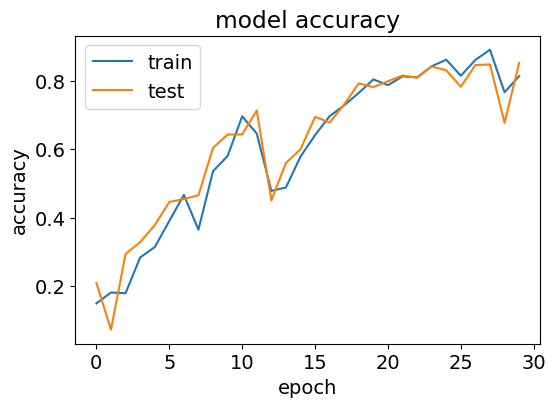

In [77]:
#summarize history for accuracy
plt.figure(figsize=(6, 4))
plt.grid(False)
plt.plot(H_1.history['accuracy'])
plt.plot(H_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

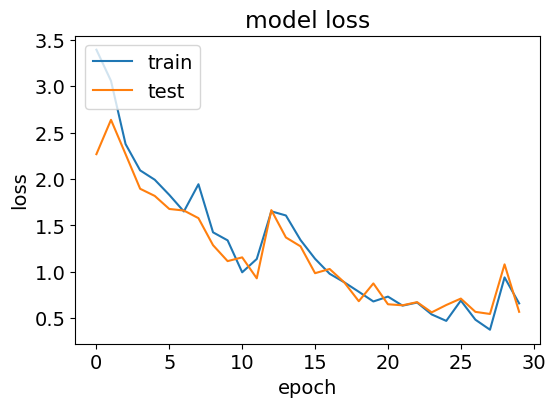

In [79]:
plt.figure(figsize=(6, 4))
plt.grid(False)
plt.plot(H_1.history['loss'])
plt.plot(H_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [71]:
#predict on test set
predictions_1 = cnn_model_1.predict(X_test)

#create target names
targetnames=['AstonMartin', 'Audi', 'Bentley', 'Bugatti', 'Ferrari',
       'FiskerAutomotive', 'Ford', 'Koenigsegg', 'Lamborghini',
       'LotusCars', 'Maserati', 'Mercedes-AMG', 'Pagani', 'Porsche']

#convert probability predictions to table using class names for column names
prediction_df_1 = pd.DataFrame(predictions_1, columns=targetnames)
print(prediction_df_1.head())

#convert predictions to class labels
predicted_labels_1 = np.argmax(predictions_1, axis=1)
print(predicted_labels_1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step
    AstonMartin          Audi       Bentley       Bugatti       Ferrari  \
0  1.406317e-10  1.278055e-07  2.371649e-06  2.014349e-06  2.319355e-03   
1  1.070426e-02  1.000882e-01  1.813267e-02  9.023226e-02  1.157314e-01   
2  5.266987e-04  3.112789e-03  1.244369e-03  8.434986e-03  2.574896e-03   
3  3.288424e-02  1.831068e-01  1.626690e-02  9.545216e-02  5.080121e-03   
4  4.728690e-26  8.235575e-23  5.383630e-19  5.214968e-19  3.607017e-18   

   FiskerAutomotive          Ford    Koenigsegg  Lamborghini     LotusCars  \
0      4.868292e-09  1.224554e-08  4.081013e-06     0.000381  4.613353e-07   
1      1.331490e-02  5.928604e-03  1.042599e-01     0.466081  3.972279e-03   
2      9.632382e-01  6.262252e-03  1.316830e-03     0.000143  1.645806e-03   
3      5.899019e-03  3.214644e-02  4.339989e-02     0.007053  5.287107e-03   
4      2.601916e-17  2.225868e-17  2.002611e-20     1.000000  2.147700e-21   

       Maserati  Mercedes-AMG        P

In [157]:
f1_1 = f1_score(y_test, predicted_labels_1, average='macro')
print(f'F1 Score: {f1_1}')

F1 Score: 0.841994557491036


<Axes: xlabel='Predicted Label', ylabel='True Label'>

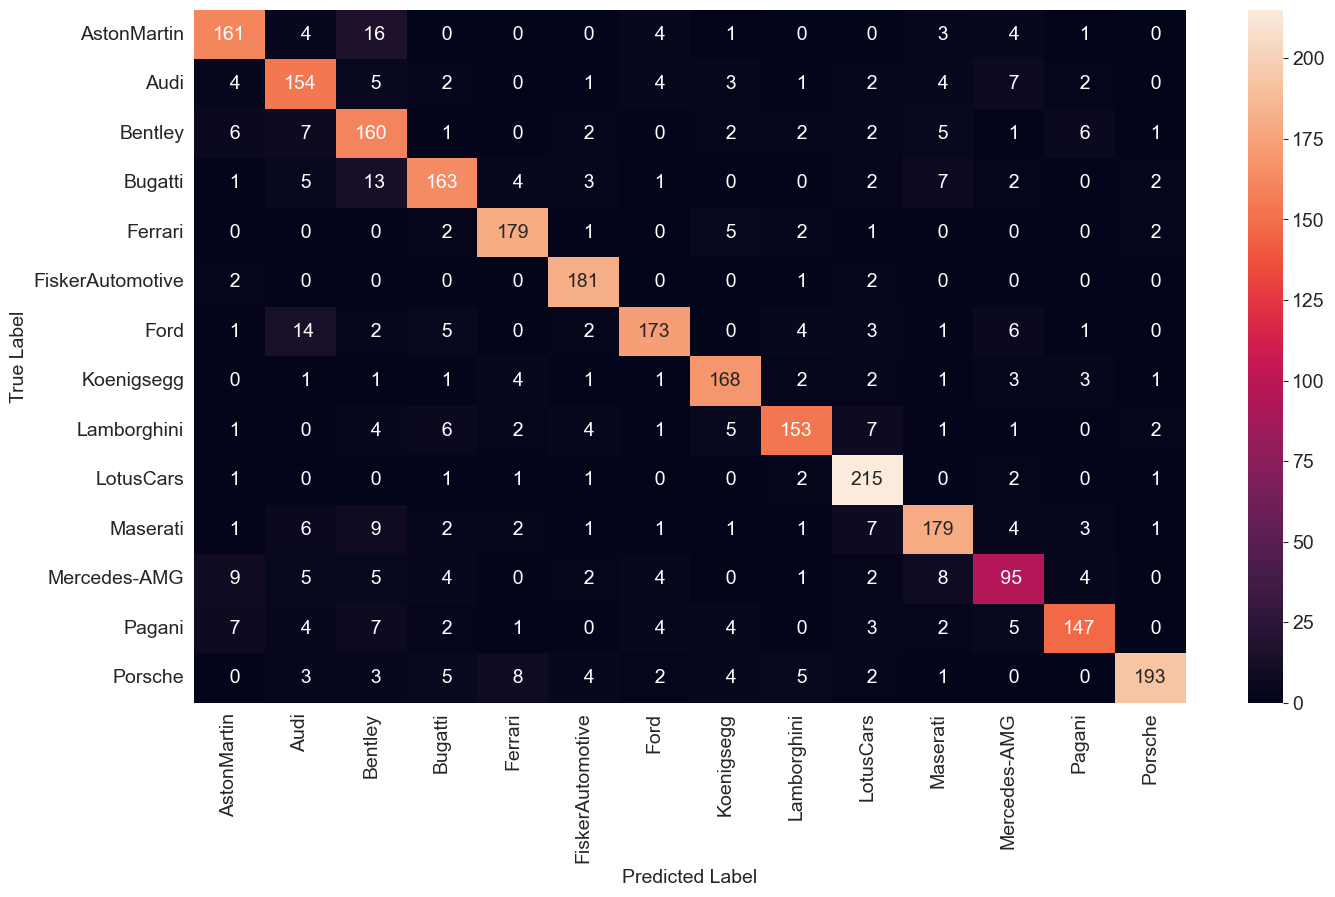

In [118]:
#confusion matrix
conf_matrix_1 = confusion_matrix(y_test, predicted_labels_1)

confusion_df_1 = pd.DataFrame(conf_matrix_1, index=targetnames, columns=targetnames)
confusion_df_1.index.name = 'True Label'
confusion_df_1.columns.name = 'Predicted Label'

sns.set_style("whitegrid")
sns.heatmap(confusion_df_1, annot=True, fmt='3g')

## 2nd CNN 

In [81]:
#CNN Model
cnn_model_2 = Sequential()

#convolutional layers with Batch Normalization and MaxPooling
cnn_model_2.add(Conv2D(kernel_size=(3, 3), filters=32, strides=(1,1), input_shape=(150, 150, 3), activation='relu'))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_2.add(Conv2D(kernel_size=(3, 3), filters=64, strides=(1,1), activation='relu'))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_2.add(Conv2D(kernel_size=(3, 3), filters=128, strides=(1,1), activation='relu'))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model_2.add(Conv2D(kernel_size=(3, 3), filters=128, strides=(1,1), activation='relu'))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))

#Dropout layer
cnn_model_2.add(Dropout(0.2))

#Global average pooling layer
cnn_model_2.add(GlobalAveragePooling2D())

#Output layer
cnn_model_2.add(Dense(14, activation='softmax'))

#get an overview
cnn_model_2.summary()

C:\Users\emili\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,046 (953.30 KB)

 Trainable params: 243,342 (950.55 KB)

 Non-trainable params: 704 (2.75 KB)

In [82]:
#timimg
start_time_2 = time.time()

#Compile the model (without cross-validation)
cnn_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Train the model 30 epochs
H_2 = cnn_model_2.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

#get the time
elapsed_time_2 = time.time() - start_time_2
print('Time needed:',elapsed_time_2)

Epoch 1/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 181s 635ms/step - accuracy: 0.4283 - loss: 1.8026 - val_accuracy: 0.6148 - val_loss: 1.1771
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 177s 644ms/step - accuracy: 0.7411 - loss: 0.8552 - val_accuracy: 0.7587 - val_loss: 0.8505
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 173s 630ms/step - accuracy: 0.8312 - loss: 0.5584 - val_accuracy: 0.8260 - val_loss: 0.6041
Epoch 4/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 176s 640ms/step - accuracy: 0.8541 - loss: 0.4682 - val_accuracy: 0.7555 - val_loss: 0.7879
Epoch 5/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 176s 642ms/step - accuracy: 0.8614 - loss: 0.4339 - val_accuracy: 0.8402 - val_loss: 0.4956
Epoch 6/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 178s 648ms/step - accuracy: 0.8640 - loss: 0.4165 - val_accuracy: 0.8383 - val_loss: 0.4895
Epoch 7/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 175s 636ms/step - accuracy: 0.8588 - loss: 0.4190 - val_accuracy: 0.8484 - val_loss: 0.4577
Epoch 8/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 172s 626ms/step - accuracy: 0.8618 -

In [83]:
#(without cross-validation)
print("Evaluate on test data")
test_loss_2, test_acc_2 = cnn_model_2.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc_2)

Evaluate on test data
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.9809 - loss: 0.0612

Test accuracy: 0.9828717112541199


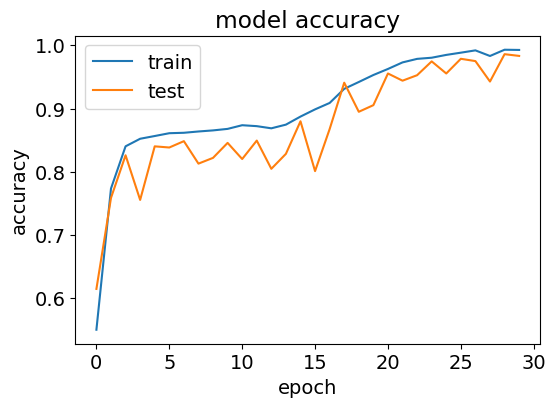

In [85]:
#summarize history for accuracy
plt.figure(figsize=(6, 4))
plt.grid(False)
plt.plot(H_2.history['accuracy'])
plt.plot(H_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

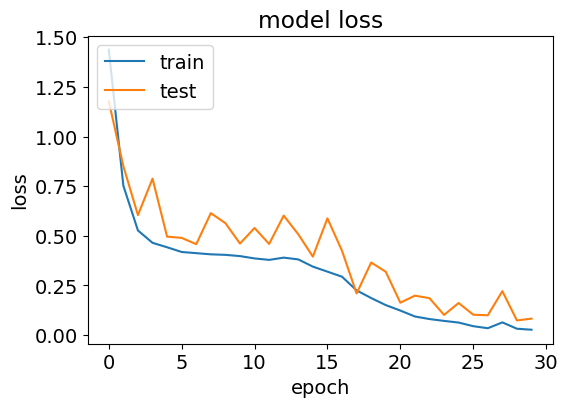

In [86]:
plt.figure(figsize=(6, 4))
plt.grid(False)
plt.plot(H_2.history['loss'])
plt.plot(H_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
#predict on test set
predictions_2 = cnn_model_2.predict(X_test)

#create target names
targetnames=['AstonMartin', 'Audi', 'Bentley', 'Bugatti', 'Ferrari',
       'FiskerAutomotive', 'Ford', 'Koenigsegg', 'Lamborghini',
       'LotusCars', 'Maserati', 'Mercedes-AMG', 'Pagani', 'Porsche']

#convert probability predictions to table using class names for column names
prediction_df_2 = pd.DataFrame(predictions_2, columns=targetnames)
print(prediction_df_2.head())

#convert predictions to class labels
predicted_labels_2 = np.argmax(predictions_2, axis=1)
print(predicted_labels_2)

86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step
    AstonMartin          Audi       Bentley       Bugatti       Ferrari  \
0  3.103622e-06  1.618506e-04  7.582948e-05  6.888948e-04  1.027187e-03   
1  5.066954e-09  8.099908e-08  3.313516e-08  2.521401e-08  2.556596e-09   
2  1.011518e-07  8.298754e-06  6.894264e-07  8.149465e-08  2.064831e-08   
3  2.415488e-06  6.327684e-04  1.817709e-06  8.952291e-08  5.387008e-06   
4  7.235178e-08  2.458306e-07  2.049123e-08  1.057508e-10  2.236122e-07   

   FiskerAutomotive          Ford    Koenigsegg   Lamborghini     LotusCars  \
0      1.138549e-04  5.625082e-06  1.946189e-04  2.795913e-04  9.373608e-05   
1      9.187517e-09  5.548214e-07  9.999987e-01  3.362486e-07  6.644520e-10   
2      9.999300e-01  7.049618e-07  1.172516e-07  2.050363e-06  3.724966e-05   
3      2.730986e-05  3.036964e-06  1.262415e-04  1.263516e-05  3.377562e-06   
4      2.187925e-07  4.790292e-07  1.303024e-07  9.997529e-01  3.293411e-08   

       Maserati  Mercedes-AMG   

In [156]:
f1_2 = f1_score(y_test, predicted_labels_2, average='macro')
print(f'F1 Score: {f1_2}')

F1 Score: 0.9823054377566481


<Axes: xlabel='Predicted Label', ylabel='True Label'>

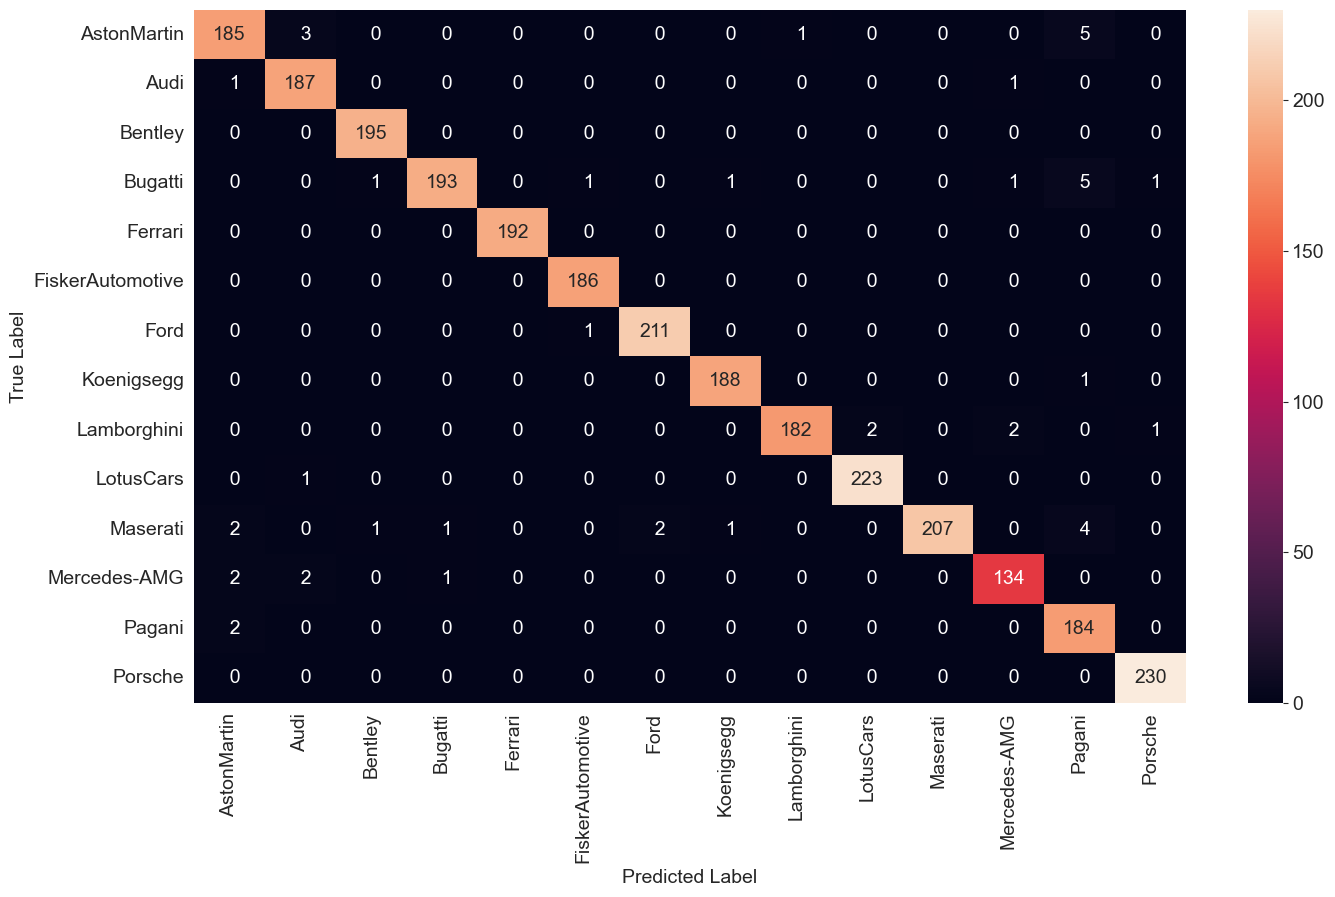

In [117]:
#confusion matrix
conf_matrix_2 = confusion_matrix(y_test, predicted_labels_2)

confusion_df_2 = pd.DataFrame(conf_matrix_2, index=targetnames, columns=targetnames)

#Set the names of the x and y axis --> for readability of the heatmap
confusion_df_2.index.name = 'True Label'
confusion_df_2.columns.name = 'Predicted Label'

sns.set_style("whitegrid")
sns.heatmap(confusion_df_2, annot=True, fmt='3g')

## SVM

In [189]:
#split it into features and labels for SVM
images = augmented_df_full.Augmented_Image
labels = augmented_df_full.Label_coded

In [190]:
X_train ,X_test, y_train, y_test=train_test_split(images, labels, test_size=0.2, random_state=42)

In [19]:
#convert tensor data to np arrays
X_train_numpy = np.array([image.numpy() for image in X_train])
X_test_numpy = np.array([image.numpy() for image in X_test])

#flatten images
X_train_flattened = X_train_numpy.reshape(len(X_train_numpy), -1)
X_test_flattened = X_test_numpy.reshape(len(X_test_numpy), -1)

#PCA
pca = PCA(n_components=10)  
X_train_pca = pca.fit_transform(X_train_flattened)
X_test_pca = pca.fit_transform(X_test_flattened)

In [14]:
#shape of pca when n_components=0.8 -- not applicable anymore, just for reference
print(X_train_pca.shape)
print(X_test_pca.shape)

(10976, 17)
(2744, 17)


In [173]:
#shape when n_componenets=10
print(X_train_pca.shape)
print(X_test_pca.shape)

(10976, 10)
(2744, 10)


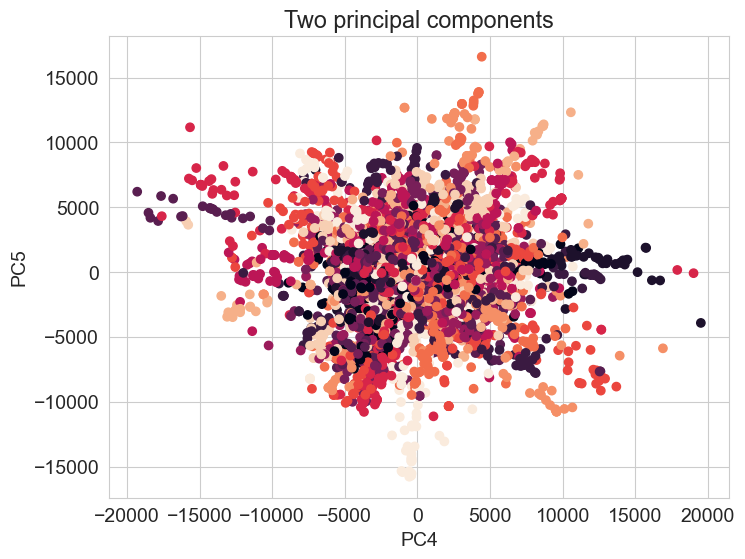

In [181]:
#plot two principal components 
plt.figure(figsize=(8,6))

plot = plt.scatter(X_train_pca[:,3], X_train_pca[:,4], c=y_train)
plt.xlabel("PC4")
plt.ylabel("PC5")
plt.title("Two principal components")
plt.show()
#-->clearly not linearly seperable, linear kernal might perform quite poorly

In [24]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [23]:
#linear SVM
model_svm_lin = LinearSVC(loss='hinge', dual=True) #hinge for linear loss
model_svm_lin.fit(X_train_pca, y_train)

print_score(model_svm_lin, X_train_pca, y_train, X_test_pca, y_test, train=True)
print_score(model_svm_lin, X_train_pca, y_train, X_test_pca, y_test, train=False)

Train Result:
Accuracy Score: 9.27%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2           3           4  \
precision    0.135484    0.003333    0.153846    0.254237    0.084529   
recall       0.087989    0.001323    0.048780    0.038610    0.508632   
f1-score     0.106689    0.001894    0.074074    0.067039    0.144966   
support    716.000000  756.000000  820.000000  777.000000  753.000000   

                    5      6           7           8           9     10  \
precision    0.102190    0.0    0.114458    0.259615    0.004587    0.0   
recall       0.017632    0.0    0.025132    0.065217    0.001161    0.0   
f1-score     0.030075    0.0    0.041215    0.104247    0.001854    0.0   
support    794.000000  873.0  756.000000  828.000000  861.000000  797.0   

                   11          12          13  accuracy     macro avg  \
precision    0.086849    0.085714    0.101335  0.092657      0.099013   
recal

C:\Users\emili\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
#poly kernel --> interrupted everytime as running time exceeded 24h for every run
param_grid_poly = {
    'C': [0.1, 1, 10, 100],  #regularization parameter
    'degree': [2, 3, 4],      #polynomial degree
    'gamma': ['scale', 'auto'], #gamma for rbf, poly and sigmoid
    'kernel': ['poly']  # Kernel type we already determine
}

#timimg
start_time_poly = time.time()

#grid search
model_svm_poly = GridSearchCV(SVC(), param_grid=param_grid_poly, cv=5, scoring='accuracy')
model_svm_poly.fit(X_train_pca, y_train)

#get the time
elapsed_time_poly = time.time() - start_time_poly

# Get the best parameters and the corresponding accuracy
best_params_poly = model_svm.best_params_
best_estimator_poly = model_svm.best_estimator_
best_accuracy_poly = model_svm.best_score_

print("Best parameters:", best_params_poly)
print("Best estimator:", best_estimator_poly) 
print("Best accuracy:", best_accuracy_poly)

In [ ]:
print_score(model_svm_poly, X_train_pca, y_train, X_test_pca, y_test, train=True)
print_score(model_svm_poly, X_train_pca, y_train, X_test_pca, y_test, train=False)
print('Running Time Poly':, elapsed_time_poly)

In [185]:
#sigmoid kernel 
param_grid_sig = {
    'C': [0.1, 1, 10, 100],  #regularization parameter
    'gamma': ['scale', 'auto'], #gamma for rbf, poly and sigmoid
    'kernel': ['sigmoid']  # Kernel type we already determine
}

#timimg
start_time_sig = time.time()

#grid search
model_svm_sig = GridSearchCV(SVC(), param_grid=param_grid_sig, cv=5, scoring='accuracy')
model_svm_sig.fit(X_train_pca, y_train)

#get the time
elapsed_time_sig = time.time() - start_time_sig

# Get the best parameters and the corresponding accuracy
best_params_sig = model_svm_sig.best_params_
best_estimator_sig = model_svm_sig.best_estimator_
best_accuracy_sig = model_svm_sig.best_score_

print("Best parameters:", best_params_sig)
print("Best estimator:", best_estimator_sig) 
print("Best accuracy:", best_accuracy_sig)

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best estimator: SVC(C=1, kernel='sigmoid')
Best accuracy: 0.14804788993033513


In [187]:
print_score(model_svm_sig, X_train_pca, y_train, X_test_pca, y_test, train=True)
print_score(model_svm_sig, X_train_pca, y_train, X_test_pca, y_test, train=False)
print('Running Time Sigmoid:', elapsed_time_sig)

Train Result:
Accuracy Score: 15.45%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2           3           4  \
precision    0.544041    0.104877    0.199095    0.085861    0.558140   
recall       0.146648    0.435185    0.107317    0.451737    0.318725   
f1-score     0.231023    0.169021    0.139461    0.144296    0.405748   
support    716.000000  756.000000  820.000000  777.000000  753.000000   

                    5           6           7           8           9  \
precision    0.115152    0.223529    0.265957    0.186770    0.503125   
recall       0.095718    0.108820    0.033069    0.115942    0.186992   
f1-score     0.104539    0.146379    0.058824    0.143070    0.272650   
support    794.000000  873.000000  756.000000  828.000000  861.000000   

                   10     11          12          13  accuracy     macro avg  \
precision    0.056782    0.0    0.201117    0.463415  0.154519      0.250562   


In [25]:
#rbf kernel
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],  # Kernel coefficient
    'coef0': [0, 0.5, 1, 2],  # Coef0 for kernels
    'kernel': ['rbf']  # Kernel type we already determine
}

#timimg
start_time_rbf = time.time()

#grid search
model_svm_rbf = GridSearchCV(SVC(), param_grid=param_grid_rbf, cv=5, scoring='accuracy')
model_svm_rbf.fit(X_train_pca, y_train)

#get the time
elapsed_time_rbf = time.time() - start_time_rbf


# Get the best parameters and the corresponding accuracy
best_params_rbf = model_svm_rbf.best_params_
best_estimator_rbf = model_svm_rbf.best_estimator_
best_accuracy_rbf = model_svm_rbf.best_score_

print("Best parameters:", best_params_rbf)
print("Best estimator:", best_estimator_rbf) 
print("Best accuracy:", best_accuracy_rbf)

Best parameters: {'C': 100, 'coef0': 0, 'gamma': 0.0001, 'kernel': 'rbf'}
Best estimator: SVC(C=100, coef0=0, gamma=0.0001)
Best accuracy: 0.3972303753770575


In [26]:
print_score(model_svm_rbf, X_train_pca, y_train, X_test_pca, y_test, train=True)
print_score(model_svm_rbf, X_train_pca, y_train, X_test_pca, y_test, train=False)
print("Time needed rbf:", elapsed_time_rbf)

Train Result:
Accuracy Score: 99.65%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2           3      4      5  \
precision    0.998599    0.988158    0.996341    0.997419    1.0    1.0   
recall       0.995810    0.993386    0.996341    0.994852    1.0    1.0   
f1-score     0.997203    0.990765    0.996341    0.996134    1.0    1.0   
support    716.000000  756.000000  820.000000  777.000000  753.0  794.0   

               6           7           8      9          10          11  \
precision    1.0    0.994709    0.981043    1.0    1.000000    0.994992   
recall       1.0    0.994709    1.000000    1.0    0.981179    1.000000   
f1-score     1.0    0.994709    0.990431    1.0    0.990500    0.997490   
support    873.0  756.000000  828.000000  861.0  797.000000  596.000000   

              12          13  accuracy     macro avg  weighted avg  
precision    1.0    1.000000  0.996538      0.996519      0.996570  
re

C:\Users\emili\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emili\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emili\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [175]:
predicted_labels_svm = model_svm_rbf.predict(X_test_pca)
f1_svm = f1_score(y_test, predicted_labels_svm, average='macro')
print(f'F1 Score: {f1_svm}')

F1 Score: 0.010245505509375604


<Axes: xlabel='Predicted Label', ylabel='True Label'>

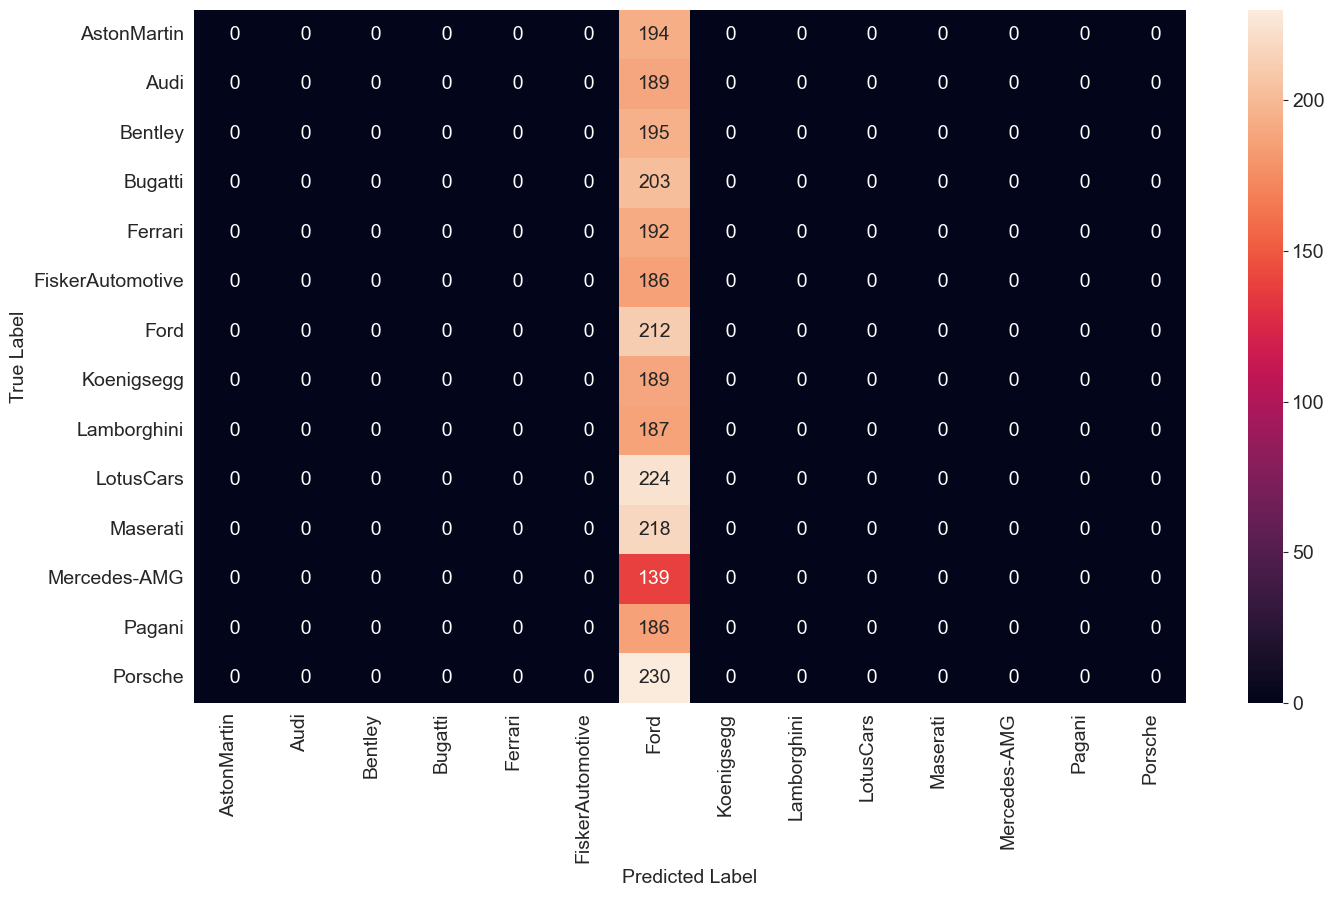

In [176]:
#confusion matrix
conf_matrix_svm = confusion_matrix(y_test, predicted_labels_svm)

targetnames=['AstonMartin', 'Audi', 'Bentley', 'Bugatti', 'Ferrari',
       'FiskerAutomotive', 'Ford', 'Koenigsegg', 'Lamborghini',
       'LotusCars', 'Maserati', 'Mercedes-AMG', 'Pagani', 'Porsche']

confusion_df_svm = pd.DataFrame(conf_matrix_svm, index=targetnames, columns=targetnames)
confusion_df_svm.index.name = 'True Label'
confusion_df_svm.columns.name = 'Predicted Label'

sns.heatmap(confusion_df_svm, annot=True, fmt='3g')

In [208]:
#check if y_test to see wha everything is accounted for "Ford" --> nothing conspicious visisble
print(y_test)

#count number of unique labels
count = np.bincount(y_test)
for num, cnt in enumerate(count):
    print(f"Label {num}: Count {cnt}")

12243    13
6714      7
4580      5
10153    10
13431     8
         ..
13474     9
43        0
17        0
6427      6
8351      9
Name: Label_coded, Length: 2744, dtype: int32
Label 0: Count 194
Label 1: Count 189
Label 2: Count 195
Label 3: Count 203
Label 4: Count 192
Label 5: Count 186
Label 6: Count 212
Label 7: Count 189
Label 8: Count 187
Label 9: Count 224
Label 10: Count 218
Label 11: Count 139
Label 12: Count 186
Label 13: Count 230


In [244]:
#number of support vectors for each class
n_support_vectors = best_estimator_rbf.n_support_

#total number of support vectors
total_support_vectors = sum(n_support_vectors)

print("Number of support vectors for each class:", n_support_vectors)
print("Total number of support vectors:", total_support_vectors)

Number of support vectors for each class: [615 646 716 680 643 671 765 668 734 739 708 522 686 755]
Total number of support vectors: 9548


## Pre-trained MobileNet

In [213]:
'''Tis will load the data with tf -- the png versions and from the already augmented images'''
folder_path=r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\Augmented Images"

# Load the data using tf.image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    folder_path,
    seed=42,
    validation_split=0.35,
    subset='training',
    image_size=(224, 224),
    batch_size=32
)

Found 13880 files belonging to 14 classes.
Using 9022 files for training.


In [214]:
val_dataset = image_dataset_from_directory(
    folder_path,
    seed=42,
    validation_split=0.35,
    subset='validation',
    image_size=(224, 224),
    batch_size=32
)
# Printing class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Found 13880 files belonging to 14 classes.
Using 4858 files for validation.
Class names: ['AstonMartin', 'Audi', 'Bentley', 'Bugatti', 'Ferrari', 'FiskerAutomotive', 'Ford', 'Koenigsegg', 'Lamborghini', 'LotusCars', 'Maserati', 'Mercedes-AMG', 'Pagani', 'Porsche']


In [215]:
#make a test dataset
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
validation_dataset = val_dataset.skip(val_batches // 5)

test_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Preparation

In [218]:
#Rescale pixel values
#model expects pixel values in [-1, 1] (right now they are [0, 255])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [219]:
#Create the base model from the pre-trained model ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [220]:
#we want the model weights to be updated during training
base_model.trainable = False

In [221]:
#look at the base model architecture
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [222]:
#Add classification head
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = models.Model(inputs, outputs)

In [223]:
model.summary()

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 14)             │        28,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,616,398 (90.09 MB)

 Trainable params: 28,686 (112.05 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [224]:
#compile the model
learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

start_time_pt = time.time()

#train the model
initial_epochs = 10
history = model.fit(train_dataset, validation_data=val_dataset, batch_size=32,epochs=initial_epochs)

elapsed_time_pt = time.time() - start_time_pt

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Time needed:', elapsed_time_pt)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 876s 3s/step - accuracy: 0.7531 - loss: 0.9294 - val_accuracy: 0.9914 - val_loss: 0.0848
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 784s 3s/step - accuracy: 0.9929 - loss: 0.0688 - val_accuracy: 0.9955 - val_loss: 0.0413
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 793s 3s/step - accuracy: 0.9973 - loss: 0.0332 - val_accuracy: 0.9963 - val_loss: 0.0273
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 760s 3s/step - accuracy: 0.9989 - loss: 0.0219 - val_accuracy: 0.9988 - val_loss: 0.0193
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 779s 3s/step - accuracy: 0.9996 - loss: 0.0149 - val_accuracy: 0.9988 - val_loss: 0.0152
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 810s 3s/step - accuracy: 0.9991 - loss: 0.0110 - val_accuracy: 0.9990 - val_loss: 0.0127
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 797s 3s/step - accuracy: 0.9995 - loss: 0.0088 - val_accuracy: 0.9988 - val_loss: 0.0119
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 797s 3s/step - accuracy: 0.9995 - loss: 0.0075 - val_accu

In [ ]:
#get results
acc_3 = history.history['accuracy']
val_acc_3 = history.history['val_accuracy']
loss_3 = history.history['loss']
val_loss_3 = history.history['val_loss']

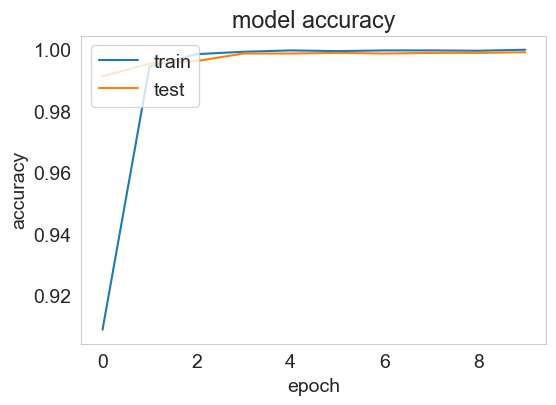

In [225]:
#plot results
#accuracy before finetuning
#summarize history for accuracy
plt.figure(figsize=(6, 4))
plt.grid(False)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

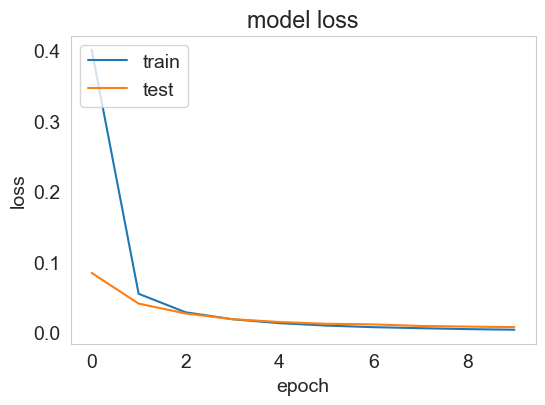

In [226]:
#loss
plt.figure(figsize=(6, 4))
plt.grid(False)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [227]:
#Fine-tune the model
# Fine-tune from this layer onwards
fine_tune_at = 100

base_model.trainable = True
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [230]:
#compile again
#NOTE: lower lr to prevent overfitting
learning_rate = 0.001 #learning rate copied from above

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate/25)

model.compile(optimizer=optimizer,  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [231]:
fine_tune_epochs = 10

total_epochs =  initial_epochs + fine_tune_epochs

start_time_pt_2 = time.time()

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

elapsed_time_pt_2 = time.time() - start_time_pt_2

# Evaluate the model
loss_pt_2, accuracy_pt_2 = model.evaluate(test_dataset)
print("Validation Loss:", loss_pt_2)
print("Validation Accuracy:", accuracy_pt_2)
print('Time needed:', elapsed_time_pt_2)

Epoch 11/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1268s 4s/step - accuracy: 0.9906 - loss: 0.0338 - val_accuracy: 0.9997 - val_loss: 9.6477e-04
Epoch 12/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1221s 4s/step - accuracy: 0.9997 - loss: 7.5784e-04 - val_accuracy: 0.9997 - val_loss: 6.2838e-04
Epoch 13/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1258s 4s/step - accuracy: 1.0000 - loss: 1.3366e-04 - val_accuracy: 0.9997 - val_loss: 4.7535e-04
Epoch 14/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1246s 4s/step - accuracy: 1.0000 - loss: 8.8700e-05 - val_accuracy: 1.0000 - val_loss: 4.0275e-04
Epoch 15/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1182s 4s/step - accuracy: 1.0000 - loss: 4.6620e-05 - val_accuracy: 0.9997 - val_loss: 4.1847e-04
Epoch 16/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1250s 4s/step - accuracy: 1.0000 - loss: 4.4781e-05 - val_accuracy: 0.9997 - val_loss: 3.5897e-04
Epoch 17/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1219s 4s/step - accuracy: 1.0000 - loss: 3.8563e-05 - val_accuracy: 0.9995 - val_loss: 5.8972e-04
Epoch 18/20
282/282 ━━━━━━━━━━━

In [232]:
acc_3 += history_fine.history['accuracy']
val_acc_3 += history_fine.history['val_accuracy']

loss_3 += history_fine.history['loss']
val_loss_3 += history_fine.history['val_loss']

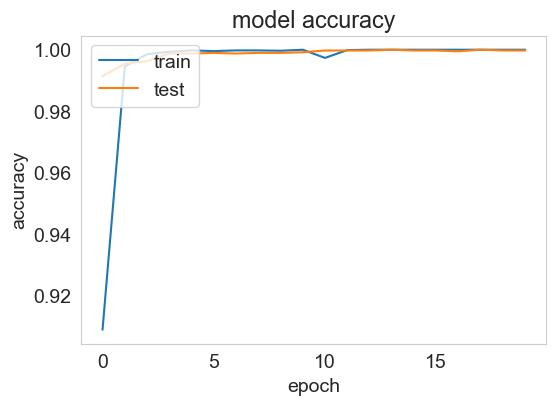

In [233]:
#accuracy
plt.figure(figsize=(6, 4))
plt.grid(False)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

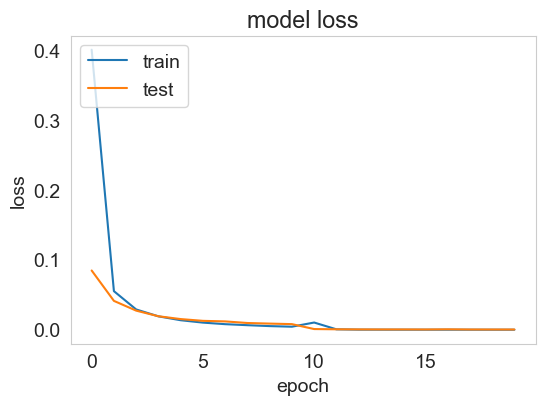

In [234]:
#loss
plt.figure(figsize=(6, 4))
plt.grid(False)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

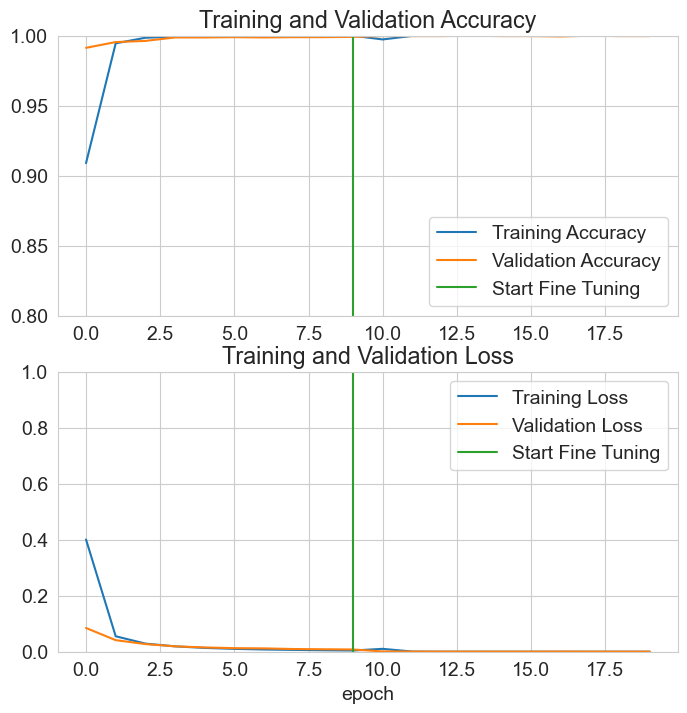

In [235]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_3, label='Training Accuracy')
plt.plot(val_acc_3, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_3, label='Training Loss')
plt.plot(val_loss_3, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [236]:
loss_fine, accuracy_fine = model.evaluate(test_dataset)
print('Test accuracy:', accuracy_fine)

30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 1.0000 - loss: 8.8127e-06
Test accuracy: 1.0


In [237]:
#get predictions
y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step


In [238]:
true_labels = []

# Iterate through the pre-fetched dataset to extract true labels
for images, labels in test_dataset:
    true_labels.extend(labels.numpy())

# Convert true labels to a NumPy array
true_labels = np.array(true_labels)

In [240]:
f1_pt = f1_score(true_labels, y_pred_labels, average='macro')
print(f'F1 Score: {f1_pt}')

F1 Score: 0.08137869821259057


<Axes: xlabel='Predicted Label', ylabel='True Label'>

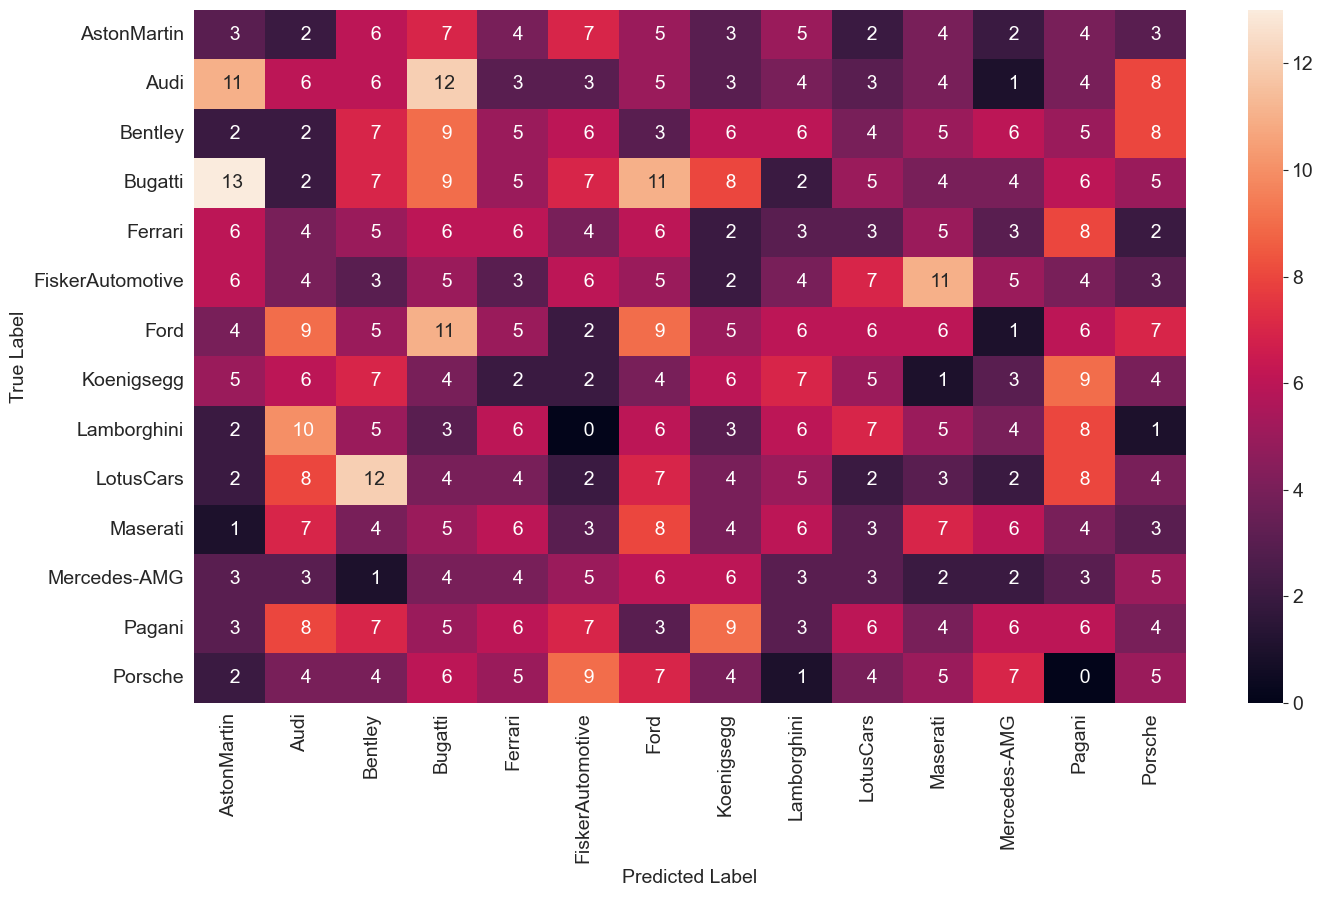

In [241]:
#confusion matrix
conf_matrix_pt = confusion_matrix(true_labels, y_pred_labels)

targetnames=['AstonMartin', 'Audi', 'Bentley', 'Bugatti', 'Ferrari',
       'FiskerAutomotive', 'Ford', 'Koenigsegg', 'Lamborghini',
       'LotusCars', 'Maserati', 'Mercedes-AMG', 'Pagani', 'Porsche']

confusion_df_pt = pd.DataFrame(conf_matrix_pt, index=targetnames, columns=targetnames)
confusion_df_pt.index.name = 'True Label'
confusion_df_pt.columns.name = 'Predicted Label'

sns.set_style("whitegrid")
sns.heatmap(confusion_df_pt, annot=True, fmt='3g')

## Running Time Plot

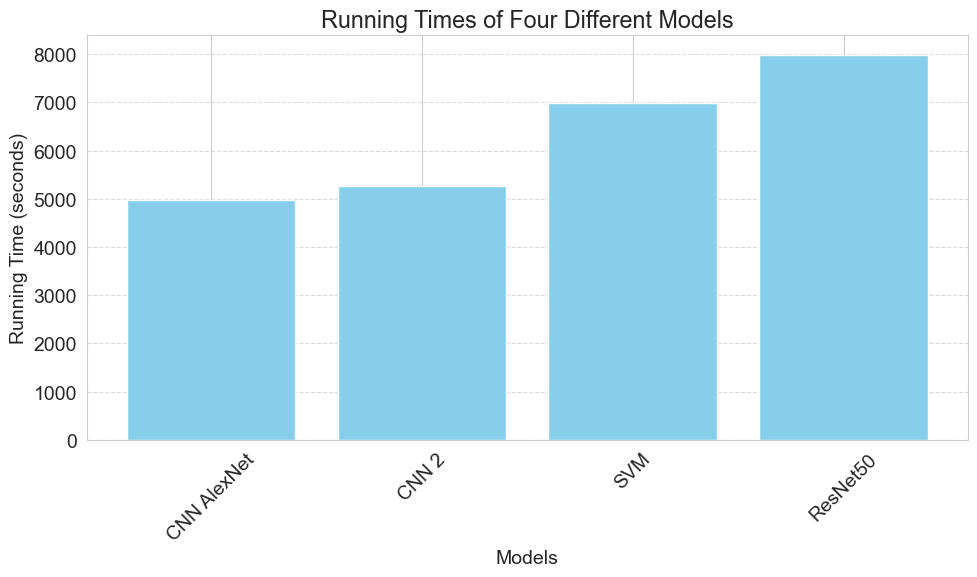

In [248]:
models = ['CNN AlexNet', 'CNN 2', 'SVM', 'ResNet50']
running_times = [elapsed_time_1, elapsed_time_2,elapsed_time_rbf, elapsed_time_pt]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, running_times, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Running Time (seconds)')
plt.title('Running Times of Four Different Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()